# MSDS7331 Lab 3 Assignment
#### Authors: Vlad Orlov, Daniel Serna, Peter Flaming, Swee Chew

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import urllib
import gzip
import re
import random
import string
import tarfile
import mimetypes
import pickle

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import holidays

from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

In [3]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.porter import PorterStemmer

In [4]:
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)

In [6]:
def maybe_download(url, filename, open_func, download_dir='.downloaded_files'):
    """
    This function downloads resource specified by URL into a specified download folder only if a file does not
    already exists. If file is compressed, the function will unpack it. The open_func will be used to read the file.
    """
    
    def retrieve(path):

        def dlProgress(count, blockSize, totalSize):
            percent = int(count*blockSize*100/totalSize)
            sys.stdout.write("\r Downloading: " + filename + "...%d%%" % min(percent, 100))

        try:
            os.stat(download_dir)
        except:
            os.mkdir(download_dir)
        if not os.path.isfile(filename):
            try:
                urllib.request.urlretrieve(link, filename, reporthook=dlProgress)
                print(' done.')
            except Exception as inst:
                os.remove(filename)
                print(inst) 

    def unpackage(path):
        a, b = mimetypes.guess_type(path)
        try:                
            if a == 'application/x-tar' and b == 'gzip':
                with tarfile.open(filename, "r:gz") as tar:
                    tar.extractall(path=download_dir)
                    return open_func(path.rsplit('.tar.gz', 1)[0])                
            elif b == 'gzip':
                with gzip.open(filename) as f:
                    return open_func(f)
            else:
                return open_func(filename)
        except Exception as inst:
            os.remove(filename)
            print(inst)                

    link = url.strip()
    filename = os.path.join(download_dir, filename) 

    retrieve(filename)                
    return unpackage(filename)

## Business Understanding 1

With a growing number of online news publishers, there is a strong competition between content providers for influence over audience. As such, media are faced with a problem of determining which content will more efficiently reach intended audience and become popular. While some reasons behind the popularity of online news might depend on hidden factors that cannot be controlled by content providers, there might be certain attributes of either news content or metadata that are within the control of a publisher. In this work, we look at a dataset collected by Kelwin Fernandes, Pedro Vinagre, and Paulo Cortez and published with paper where they proposed using proactive Intelligent Decision Support System (IDSS) for forecasting news popularity expressed in number of shares <sup>[1]</sup>. We not only revisited statistical features derived from the words that make up each article collected by the authors but also attempted to enrich the dataset with our own attributes in attempt to build a superior model that can be used to forecast traction of online news.

In this assignment, we extracted text of every article, that can be found in Online News Popularity dataset (https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity) and transformed it to a vector of term frequency–inverse document frequency (TF-IDF) statistic. We used k-means algorithm to perform clustering analysis on the data channel type. We are interested in exploring whether articles of the same data channel type have similar TF-IDF statistics of certain terms, and whether one can utilize TF-IDF statistics to distinctly classify the data channel type of an article. 

To measure the effectiveness of a good clustering algorithm, we decided to use Adjusted Rand Index (ARI) to evaluate the performance of chosen clustering algorithms. ARI requires knowledge of the ground truth class assignments and since we have that information available, we can use ARI to measure the similarity between the true and predicted assignments. Also, ARI makes no assumption about the cluster structure and thus it can be used to compare any clustering algorithm. The range is [-1, 1], with negative ARIs indicating independent labelings and positive values denoting similar clusterings. ARI of 1.0 suggests the perfect match score.

$$ARI = \frac{RI - E[RI]}{max(RI) - E[RI]} $$ 

where RI stands for raw Rand index and E[RI] is the expected RI of random labelings. 

*This formula is referenced from the following website: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation.* 

The outcome of our clustering analysis will provide insightful results that could be invaluable to the digital marketing space. Knowing that certain word choices are highly used, which could be translated to hot topics that everyone talks about. With that knowledge, a company could optimize content for shareability, in order to increase ROAI (return on ad investment) while also reducing CPL (cost per lead) metrics. This benefit would have an immediate positive effect on the company's bottom line. Lead generation strategies are highly dependent on the shareability of content - the greater the number of shares, the higher the number of new leads. This is extremely important for the long term health of a business. 

## Data Understanding 1

First, we download article's text data that has been collected by us in our first assignment, where we retrieved the content of online news articles from Mashable website using a simple HTML scraper and provided URLs.

We will do additional cleanup of the text data and convert it to TFIDF vectors for this assignment.

### Transform Text to TFIDF

In [7]:
text_df = maybe_download('https://bit.ly/2Dygo5T', 'OnlineNewsPopularityData.tar.gz', pd.read_parquet)
text_df.shape

(39644, 3)

We check to see if there are any URLs for which we couldn't retrieve text. 

In [8]:
(text_df[text_df.status_code != 200].shape,
 text_df[text_df.text.isna()].shape)

((15, 3), (15, 3))

We remove all instances, where HTTP status code != 200 (Status OK), to drop unsuccessful text retrieval. These are the articles that do not exist anymore, since the original dataset was collected in 2014. 

In [9]:
text_df = text_df[text_df.status_code == 200]
text_df.shape

(39629, 3)

In [10]:
text_df.head(10)

,status_code,url,text
0,200,http://mashable.com/2013/01/07/amazon-instant-video-browser/,"\nHaving trouble finding something to watch on Amazon Instant Video? The retailer launched Monday an experimental browsing tool that lets users discover movies and TV shows based on their genre preferences or simply the mood they're in.\nMovies and shows are divided up into categories, some of which bear the names of genres (i.e., ""Comedy"" and ""Mystery/Thriller""), and others which are labeled by mood, such as ""Feel-Good"" and ""Exciting."" Users can toggle between TV shows and movies, and apply filters to show only videos that are available for free viewing to Prime subscribers, or ones that bear G or PG ratings.\nIt's pretty basic, but it sure beats the haphazard organization of Amazon's current Instant Video page, which mixes rows of new releases with bestsellers and personal recommendations.\nThe move is the latest in a series of investment's Amazon is making in its streaming video platform. Last week, the company inked a licensing agreement with A+E Networks to bring past seasons..."
1,200,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,"\nThe Associated Press is the latest news organization to experiment with trying to make money from Twitter by using its feed to advertise for other companies. \nThe AP announced Monday that it will share sponsored tweets from Samsung throughout this week for the International CES taking place in Las Vegas. The news service will let Samsung post two tweets per day to the AP's Twitter account, which has more than 1.5 million users, and each of these tweets will be labeled ""SPONSORED TWEETS.""\nThis marks the first time that the AP has sold advertising on its Twitter feed, and the company says it spent months developing guidelines to pave the way for this and other new media business models. \nFor this particular promotion, Samsung will provide the sponsored tweets and non-editorial staff at the AP will handle the publishing side. In this way, the company hopes to maintain a clear dividing line between its editorial and advertising operations on Twitter.\n""We are thrilled to be takin..."
2,200,http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,"\nIt looks like 2012 was a pretty good year for Apple's App Store.\nApple announced Monday that the App Store has now passed 40 billion downloads since launching in 2008, with nearly 20 billion apps downloaded in 2012. The company had a particularly strong holiday season, with 2 billion app downloads in December alone.\nThe App Store hit the 25 billion mark in March and passed 35 billion in October. \nâ€œIt has been an incredible year for the iOS developer community,â€ said Eddy Cue, Appleâ€™s senior vice president of Internet Software and Services, in a statement. â€œDevelopers have made over $7 billion on the App Store, and we continue to invest in providing them with the best ecosystem so they can create the most innovative apps in the world.â€\nJust as importantly, the company revealed that there are now more than 500 million active accounts in the App Store, showing the growth of Apple's user base. \nIn total, there are now 775,000 apps in Apple's App Store, with more than ..."
3,200,http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,"\nWhen it comes to college football, NASA astronaut Kevin Ford is Irish through and through. Ford will be rooting for Notre Dame all the way from space during the BCS Championship game against Alabama tonight.\nFord is currently living on the International Space Station, where he commands a six-man team, but tonight his heart will be with Notre Dame —his alma mater —when the team faces off with Alabama's Crimson Tide in Miami.\n""The team's played great,"" Ford said in a recent interview with Notre Dame officials on NASA TV. ""Obviously the defense is very special, and the offense is just really clicking. I'm looking forward to a great game on the seventh of January.""\n\nFord has been liv

Since there is some HTML left in the text, we will do some data cleaning on what is left from HTML tags using regular expressions.

In [11]:
def cleanup_text(text): 
    exps = ['[{](["].+["][:].+)+[}]',
            '\\\n', '[<]\s*\w+\s*/[>]',
            'window[.][_]msla[=].*;',
            'function[(]\s*[)]\s*{.*}']

    for e in exps:
        text = re.sub(e, '', text)
    return text

In [12]:
text_df['text'] = text_df.text.apply(cleanup_text)

In [13]:
text_df.sample(n=10)

,status_code,url,text
18523,200,http://mashable.com/2014/01/08/colorado-restaurant-marijuana-dinner-pairings/,"A Colorado restaurant is addressing the eternal question: What kind of weed goes best with a Honey Miso Salmon? Hapa Sushi, which was behind a print campaign in 2009 that showed a map of locations of medical marijuana dispensaries and Hapa locations in the state, has a new ad effort that suggests pot-and-dinner pairings, according to Advertising Age.See also: Ben & Jerry's Gets High Marks for Colorado Marijuana TweetAmong the suggestions: Blue Dream goes well with the Katsu Curry, and Pakistani Kush is a nice complement to Pakalolo Shrimp. In addition to the menu, the ads also advertise a dining room that is ""ergonomically designed to reduce paranoia."" Tagline: Happy Legalization.The ad effort comes after Colorado Amendment 64, which allows for commercial sales of marijuana to adults older than 21, went into effect on Jan. 1.BONUS: The History of Marijuana in the U.S [VIDEO]Image: Getty/Alex Trautwig"
84,200,http://mashable.com/2013/01/08/ro-marley-ces-2013/,"CES 2013 Google+ Hangout with Ro MarleyRo Marley at CES 2013Ro Marley, the son of late reggae artist Bob Marley and head of audio and accessory company House of Marley, joined Mashable for a Google+ Hangout Tuesday in the CES 2013 showroom.Tech Editor Pete Pachal preps for the Hangout wearing House of Marley headphones.Marley and Lifestyle Editor Andrea Smith before the Hangout.Marley and Smith share a laptop for the Hangout.The three participants engaging in insightful banter.Marley shows off products from his House of Marley collection.Smith, rocking the House of Marley headphones, and Marley after the Hangout.Pachal, Smith and Marley at the conclusion of the Hangout.The CES 2013 showroom opened for business Tuesday, and Vegas is buzzing with innovation, new gadgets and devices. Ro Marley, the son of late reggae artist Bob Marley and head of audio and accessory company House of Marley, stepped away from the excitement to join Mashable for a Google+ Hangout.Marley is attending CE..."
1562,200,http://mashable.com/2013/02/03/alicia-keys-super-bowl-piano/,"Unlike recent Super Bowl national anthem performances from other musicians, Alicia Keys opted to play piano while singing ""The Star-Spangled Banner."" Viewers on Twitter had mixed reviews for Keys, who just days before game day was appointed BlackBerry's global creative director.Keys is the first artist to use a piano during a national anthem performance at a Super Bowl since Billy Joel in 2007.I love Alicia Keys but dear me,come on. That had to be one of the longest anthems ever. It was no Whitney Houston #alltimefavourite— Sara Orlesky (@saraorlesky) February 3, 2013I clocked Alicia Keys at 156.4 seconds, breaking the SB mark of 152 seconds by Natalie Cole and choir in 1994.— David Barron (@dfbarron) February 3, 2013DID ALICIA KEYS STOP IN THE MIDDLE OF HER PERFORMANCE TO TALK ON THE PHONE— America's Car (@PTCruiserUSA) February 3, 2013Sandy hook elementary chorus singing America the beautiful and Alicia keys national anthem makes me proud to be American— Kate Upton (@KateUpton) ..."
26837,200,http://mashable.com/2014/11/17/darren-brown-ferguson-shooting-videos/,"Newly revealed police radio recordings and surveillance footage provide a more complete timeline of the day Ferguson Police Officer Darren Wilson fatally shot 18-year-old Michael Brown Jr.The audio, obtained by the St. Louis Post-Dispatch through state public records laws, shows that the entire encounter happened in less than 90 seconds. The recordings are embedded throughout the Post-Dispatch's report.See also: Michael Brown's parents take his case to UN's anti-torture committeeThe Post-Dispatch also published Ferguson Police Department surveillance videos that reportedly show Wilson leaving for the hospital about two hours after the shooting with other officers and a union lawyer, then returning two and a half hours later. The new details come as 

Finally, we convert each article to a TF-IDF vector.

In [14]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20000)
tfidf.fit(text_df['text'])
tokenizer = tfidf.build_tokenizer()

In [15]:
tfidf_data = {
        'urls': text_df.url,
        'words': [tokenizer(text) for text in text_df['text']],
        'features': tfidf.transform(text_df['text']),
        'vocabulary': tfidf.vocabulary_
}

In [16]:
tfidf_data.keys(), len(tfidf_data['urls']), tfidf_data['features'].shape, len(tfidf_data['vocabulary'])

(dict_keys(['urls', 'words', 'features', 'vocabulary']),
 39629,
 (39629, 20000),
 20000)

We also download the original dataset to obtain features needed for the clustering analysis. 

In [17]:
df = maybe_download('https://bit.ly/2MmFvve', 'OnlineNewsPopularity.csv.gz', pd.read_csv)
df.columns = map(lambda x: x.strip(), df.columns)
df.shape

(39644, 61)

Let's drop the instances for which we don't have TFIDF features. 

In [18]:
dropped_urls = [u for u in df.url if u not in tfidf_data['urls'].values]
df = df[~df.url.isin(dropped_urls)]
df.shape

(39629, 61)

Using the six binary variables from the original dataset that describe the data channel type of the news articles, we create a new variable, *channel*, to store the information. 

In [19]:
df.loc[df.data_channel_is_lifestyle == 1, 'channel'] = 'lifestyle'
df.loc[df.data_channel_is_entertainment == 1, 'channel'] = 'entertainment'
df.loc[df.data_channel_is_bus == 1, 'channel'] = 'bus'
df.loc[df.data_channel_is_socmed == 1, 'channel'] = 'socmed'
df.loc[df.data_channel_is_tech == 1, 'channel'] = 'tech'
df.loc[df.data_channel_is_world == 1, 'channel'] = 'world'
df.channel = df.channel.fillna('other')

In [20]:
X = tfidf_data['features']
y = df.channel

X.shape, y.shape

((39629, 20000), (39629,))

In [21]:
X

<39629x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 6894387 stored elements in Compressed Sparse Row format>

At the end of preprocessing step, we obtained a sparse matrix (39629 x 20000), where rows are TFIDF vectors of 39629 articles from Mashable website. Each vector consists of 20000 floating-point numbers, each representing the frequency of each word that is pulled from all the articles.

For the rest of this work, we will use the full dataset for clustering, but occasionally we will use the sample size of 3,000 articles to speed up computations.

In [22]:
X_sample = np.random.RandomState(seed=42).permutation(X.toarray())[:3000]

The features are then normalized to scale input vectors to unit norms, which is a common operation for text clustering, which relies on the magnitude of values, such as distance measures used in k-nearest neighbors.

In [23]:
from sklearn.preprocessing import normalize

X_normalized = normalize(X, axis=1)
X_normalized_sample = normalize(X_sample, axis=1)

## Data Understanding 2

Since we are going to compare our clusters to the data channel, let's plot this attribute and see how its values are distributed.

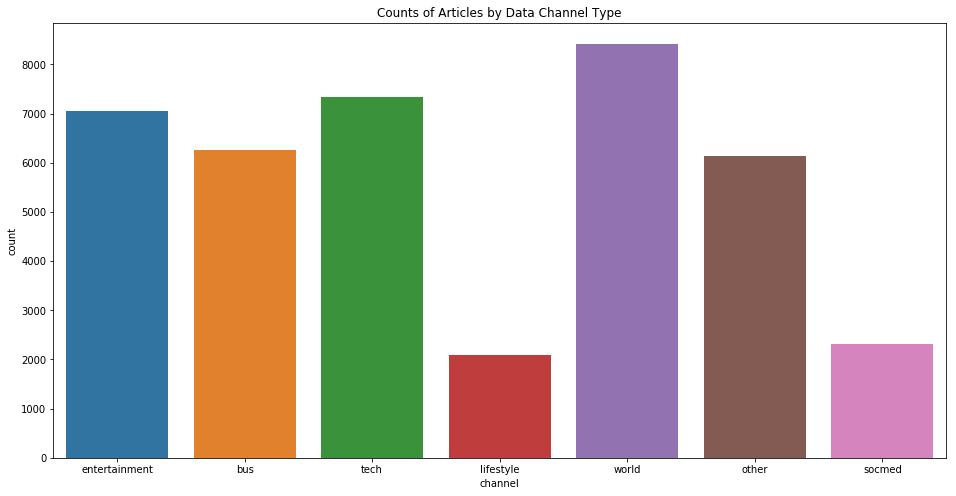

In [24]:
ax = sns.countplot(df.channel)
_ = ax.set(title='Counts of Articles by Data Channel Type')

As we noted in our previous work, all levels of variable *channel* seem to have more or less the same number or records but the channel type _lifestyle_ and _socmed_ are underrepresented in our data. _World_ channel has the highest number of records. 

We will next examine the mean number of shares by data channel type to see whether a specific channel recieves more shares than the others. 

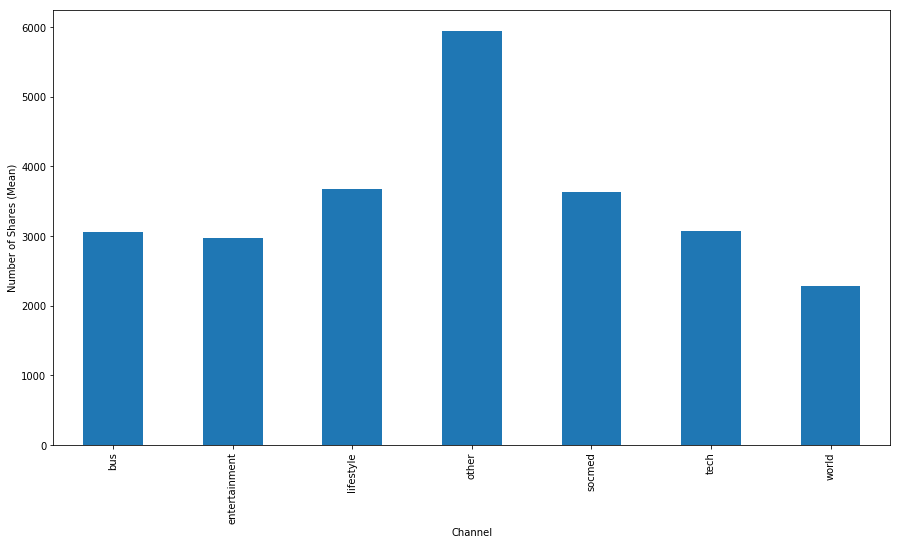

In [25]:
f, ax = plt.subplots(figsize=(15, 8))

dfGroupedDataChannelType = df.groupby('channel')
shares = dfGroupedDataChannelType.shares.mean()
ax = shares.plot(kind="bar")
ax.set_ylabel('Number of Shares (Mean)')
ax.set_xlabel('Channel')
ax.set_title('Mean of Shares by Data Channel Type')
ax.set_facecolor('xkcd:white')
ax.grid(False)

The plot above indicates that on average "Other" category has the most number of shares, and "World" category has the least number of shares. Given that the dataset contains the highest count of "World" articles as shown in the previous graph, we can say that a higher number of articles doesn't translate to a higher number of shares on average. Also, "Lifestyle" has the lowest article count but the mean number of shares is the second highest.     

In [26]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

Next, we will visualize our sample of 3000 articles using t-Distributed Stochastic Neighbor Embedding (t-SNE) method. It allows us to optimize and produces significantly better visualizations for our high-dimensional dataset. For more information on the t-SNE method, plese refer to the following paper: http://www.cs.toronto.edu/~hinton/absps/tsne.pdf, https://lvdmaaten.github.io/tsne/

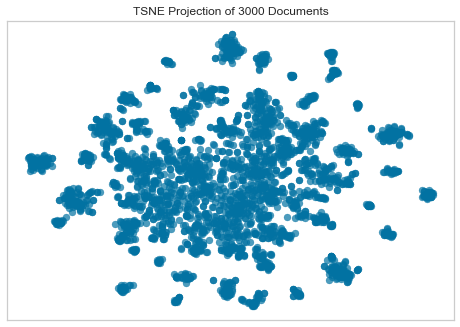

In [27]:
tsne = TSNEVisualizer()
tsne.fit(X_sample)
tsne.poof()

It's difficult to spot clusters here, but there are definetly some small islands of points which suggests we might have some chance in splitting the data into disjoint groups. t-SNE does not preserve Euclidean distances thus rendering any attempts to interpret this visualization is useless. Instead, we will now try to apply k-means algorithm to see whether we can automatically assign each atricle to one of the topics.

## Modeling and Evaluation 1

First, we will do a straightforward k-means clustering on TF-IDF dataset. Since there are 7 different topics, we choose *n_clusters* to be 7. 

In [28]:
from sklearn.cluster import KMeans

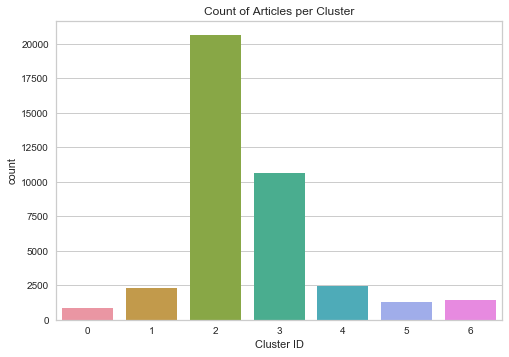

In [29]:
kmeans = KMeans(n_clusters=7, random_state=42, init='k-means++', n_jobs=-1)
kmeans.fit(X_normalized)
ax = sns.countplot(kmeans.labels_)
_ = ax.set(xlabel='Cluster ID', title='Count of Articles per Cluster')

While k-means did split the data into 7 different groups, most of the data points have been assigned to either cluster 2 or 3.

Next, we will try to find the "optimal" number of clusters using "elbow" method.

In [30]:
def kmeans_elbow(data):
    all_k = []
    all_sse = []

    for k in range(1, 100, 10):
        sys.stdout.write('\rK={}'.format(k))
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_jobs=-1)
        kmeans.fit(data)
        all_k.append(k)
        all_sse.append(kmeans.inertia_)
    return all_k, all_sse

In [31]:
kmeans_elbow_results = kmeans_elbow(X_normalized_sample)

K=91

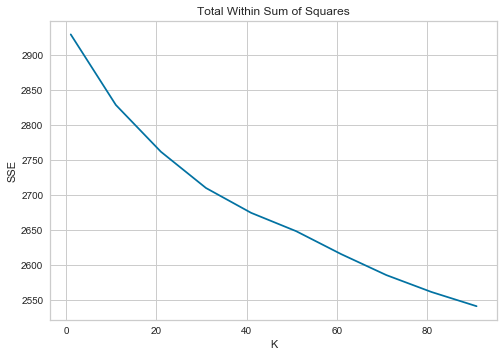

In [32]:
ax = sns.lineplot(x=kmeans_elbow_results[0], y=kmeans_elbow_results[1])
_ = ax.set(xlabel='K', ylabel='SSE', title='Total Within Sum of Squares')

A line chart of the SSE plot above shows no clear elbow point, which might indicate that either we have selected incorrect clustering method or there is only a single cluster in our data. 

## Modeling and Evaluation 2

Let's compare Scikit-Learn's implementation of k-means (which uses Euclidean distance) and NLTK's k-means with Cosine Similarity. Our hope is that a better distance metric will produce better clusters.

We encountered a problem in the implementation of NLTK. The implementation does not correctly handle the value of np.nan inside the \_cluster\_vectorspace method, and np.nan leads to a poor convergence of the method. To fix this problem, we had to take the code from https://www.nltk.org/_modules/nltk/cluster/kmeans.html, debug it and make the fix right inside the next cell.

In [33]:
import copy
import random
import sys

try:
    import numpy
except ImportError:
    pass


from nltk.cluster.util import VectorSpaceClusterer
from nltk.compat import python_2_unicode_compatible


class KMeansClusterer(VectorSpaceClusterer):
    """
    The K-means clusterer starts with k arbitrary chosen means then allocates
    each vector to the cluster with the closest mean. It then recalculates the
    means of each cluster as the centroid of the vectors in the cluster. This
    process repeats until the cluster memberships stabilise. This is a
    hill-climbing algorithm which may converge to a local maximum. Hence the
    clustering is often repeated with random initial means and the most
    commonly occurring output means are chosen.
    """

    def __init__(
        self,
        num_means,
        distance,
        repeats=1,
        conv_test=1e-6,
        conv_max_iterations=1e3,
        initial_means=None,
        normalise=False,
        svd_dimensions=None,
        rng=None,
        avoid_empty_clusters=False,
    ):

        """
        :param  num_means:  the number of means to use (may use fewer)
        :type   num_means:  int
        :param  distance:   measure of distance between two vectors
        :type   distance:   function taking two vectors and returing a float
        :param  repeats:    number of randomised clustering trials to use
        :type   repeats:    int
        :param  conv_test:  maximum variation in mean differences before
                            deemed convergent
        :type   conv_test:  number
        :param  initial_means: set of k initial means
        :type   initial_means: sequence of vectors
        :param  normalise:  should vectors be normalised to length 1
        :type   normalise:  boolean
        :param svd_dimensions: number of dimensions to use in reducing vector
                               dimensionsionality with SVD
        :type svd_dimensions: int
        :param  rng:        random number generator (or None)
        :type   rng:        Random
        :param avoid_empty_clusters: include current centroid in computation
                                     of next one; avoids undefined behavior
                                     when clusters become empty
        :type avoid_empty_clusters: boolean
        """
        VectorSpaceClusterer.__init__(self, normalise, svd_dimensions)
        self._num_means = num_means
        self._distance = distance
        self._max_difference = conv_test
        assert not initial_means or len(initial_means) == num_means
        self._means = initial_means
        assert repeats >= 1
        assert not (initial_means and repeats > 1)
        self._repeats = repeats
        self._rng = rng if rng else random.Random()
        self._avoid_empty_clusters = avoid_empty_clusters
        self.conv_max_iterations = conv_max_iterations

    def cluster_vectorspace(self, vectors, trace=False):
        if self._means and self._repeats > 1:
            print('Warning: means will be discarded for subsequent trials')

        meanss = []
        for trial in range(self._repeats):
            if trace:
                print('k-means trial', trial)
            if not self._means or trial > 1:
                self._means = self._rng.sample(list(vectors), self._num_means)
            self._cluster_vectorspace(vectors, trace)
            meanss.append(self._means)

        if len(meanss) > 1:
            # sort the means first (so that different cluster numbering won't
            # effect the distance comparison)
            for means in meanss:
                means.sort(key=sum)

            # find the set of means that's minimally different from the others
            min_difference = min_means = None
            for i in range(len(meanss)):
                d = 0
                for j in range(len(meanss)):
                    if i != j:
                        d += self._sum_distances(meanss[i], meanss[j])
                if min_difference is None or d < min_difference:
                    min_difference, min_means = d, meanss[i]

            # use the best means
            self._means = min_means


    def _cluster_vectorspace(self, vectors, trace=False):
        if self._num_means < len(vectors):
            # perform k-means clustering
            converged = False
            iter_n = 0
            while not converged:                
                # assign the tokens to clusters based on minimum distance to
                # the cluster means
                clusters = [[] for m in range(self._num_means)]
                for vector in vectors:
                    index = self.classify_vectorspace(vector)
                    clusters[index].append(vector)

                if trace:
                    print('iteration')
                # for i in range(self._num_means):
                # print '  mean', i, 'allocated', len(clusters[i]), 'vectors'

                # recalculate cluster means by computing the centroid of each cluster
                new_means = list(map(self._centroid, clusters, self._means))

                # measure the degree of change from the previous step for convergence
                difference = self._sum_distances(self._means, new_means)
                if difference < self._max_difference or numpy.isnan(difference): #our fix is here
                    converged = True
                if iter_n >= self.conv_max_iterations:
                    converged = True

                # remember the new means
                self._means = new_means
                iter_n += 1
                if trace:
                    sys.stdout.write('\rIteration {}, difference {}'.format(iter_n, difference))

    def classify_vectorspace(self, vector):
        # finds the closest cluster centroid
        # returns that cluster's index
        best_distance = best_index = None
        for index in range(len(self._means)):
            mean = self._means[index]
            dist = self._distance(vector, mean)
            if best_distance is None or dist < best_distance:
                best_index, best_distance = index, dist
        return best_index


    def num_clusters(self):
        if self._means:
            return len(self._means)
        else:
            return self._num_means


    def means(self):
        """
        The means used for clustering.
        """
        return self._means


    def _sum_distances(self, vectors1, vectors2):
        difference = 0.0
        for u, v in zip(vectors1, vectors2):
            difference += self._distance(u, v)
        return difference

    def _centroid(self, cluster, mean):
        if self._avoid_empty_clusters:
            centroid = copy.copy(mean)
            for vector in cluster:
                centroid += vector
            return centroid / (1 + len(cluster))
        else:
            if not len(cluster):
                sys.stderr.write('Error: no centroid defined for empty cluster.\n')
                sys.stderr.write(
                    'Try setting argument \'avoid_empty_clusters\' to True\n'
                )
                assert False
            centroid = copy.copy(cluster[0])
            for vector in cluster[1:]:
                centroid += vector
            return centroid / len(cluster)

    def __repr__(self):
        return '<KMeansClusterer means=%s repeats=%d>' % (self._means, self._repeats)

We now apply modified NLTK's k-means algorithm to our data and see what clusters we get. 

In [34]:
kclusterer = KMeansClusterer(7, distance=nltk.cluster.util.cosine_distance, repeats=15, avoid_empty_clusters=True)
nltk_labels = kclusterer.cluster(X_normalized.toarray(), assign_clusters=True)

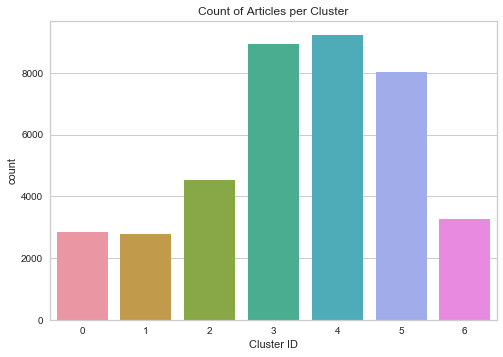

In [35]:
ax = sns.countplot(nltk_labels)
_ = ax.set(xlabel='Cluster ID', title='Count of Articles per Cluster')

Using the NLTK's implementation of k-means, we got a better distribution of items across 7 clusters compared to the Scikit Learn's implementation.

We are also curious whether the NLTK's implementation works better with the "elbow" method in finding the "optimal" number of clusters.

In [36]:
def nltk_kmeans_elbow(data):

    def calc_sse(data, kclusterer, assigned_clusters):
        c_centers = kclusterer.means()
        d = np.array([nltk.cluster.util.cosine_distance(v, c_centers[i]) for i, v in zip(assigned_clusters, data) 
                     if np.count_nonzero(v) > 0])
        return np.power(d, 2).sum()

    all_k = []
    all_sse = []

    for k in range(1, 100, 10):
        sys.stdout.write('\rK={}'.format(k))
        data = X_normalized_sample
        kclusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=15, avoid_empty_clusters=True)
        assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
        sse = calc_sse(data, kclusterer, assigned_clusters)
        all_k.append(k)
        all_sse.append(sse)
    
    return all_k, all_sse

In [37]:
nltk_elbow_results = nltk_kmeans_elbow(X_normalized_sample)

K=91

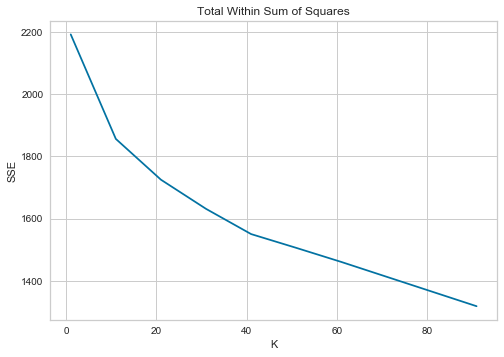

In [38]:
ax = sns.lineplot(x=nltk_elbow_results[0], y=nltk_elbow_results[1])
_ = ax.set(xlabel='K', ylabel='SSE', title='Total Within Sum of Squares')

With the NLTK's implementation of k-means, the SSE plot above shows a better result (a less smooth curve), however, it still does not have a clear elbow point.

One way to evaluate k-means is to look at what articles have been assigned to each cluster. 

In [39]:
nltk_clusters = pd.DataFrame(list(zip(nltk_labels, tfidf_data['urls'], tfidf_data['words'])),
                             columns=['label', 'url', 'words'])
nltk_clusters = nltk_clusters.merge(df[['url', 'channel']], on='url')

In [40]:
nltk_clusters[nltk_clusters.label == 0][:5]

,label,url,words,channel
12,0,http://mashable.com/2013/01/07/creature-cups/,"[Cream, and, sugar, can, only, do, so, much, If, you, really, want, to, liven, up, your, next, cup, of, coffee, beyond, the, traditional, boundaries, of, lactose, and, artificial, sweeteners, consider, one, of, these, mugs, They, re, called, Creature, Cups, and, they, re, exactly, what, you, hope, they, would, be, Each, mug, is, specially, designed, with, creepy, surprise, dwelling, at, the, bottom, skulls, tarantulas, alligators, and, lobsters, the, whole, gang, there, Fill, one, to, the, brim, hand, it, to, friend, and, wait, for, the, scream, Just, be, sure, you, re, standing, outside, the, spit, zone, SEE, ALSO, 12, Coffee, Mugs, for, ...]",other
14,0,http://mashable.com/2013/01/07/downton-abbey-tumblrs/,"[Downton, Abbey, Tumblrs1, Edith, With, Googly, EyesLady, Edith, Crawley, gets, the, Muppet, treatment, Image, courtesy, of, Edith, With, Googly, Eyes2, Downton, AbbeyonceBeyoncÃ, and, Destiny, Child, describe, Downton, Abbey, scenes, All, the, singles, ladies, will, love, it, Image, courtesy, of, Downton, AbbeyoncÃ, Arrested, DowntonArrested, Development, Downton, Abbey, Arrested, Downton, Hope, you, packed, bail, money, Crawley, family, Image, courtesy, of, Arrested, Downton4, Downton, PawneeLeslie, Knope, aristocratic, ambitions, realized, Image, courtesy, of, Downton, Pawnee5, Downton, Abbey, LampsThe, real, stars, illuminate, the, castle, Image, courtesy, of, Downton, Abbey, Lamps6, Telegrams, From, DowntonTexts, From, Last, Night, visit, the, Yorkshire, countryside, Image, courtesy, of, Telegrams, From, ...]",other
86,0,http://mashable.com/2013/01/08/snow-dogs/,"[Snow, DogsWarning, Snow, excitement, may, cause, eyes, to, pop, out, of, head, Image, courtesy, of, Flickr, oakleyoriginalsEwoks, love, snow, too, Image, courtesy, of, Imgur, Freeeedom, Image, courtesy, of, ImgurBall, Snow, Ball, Snow, Image, courtesy, of, Flickr, soggydanHot, dog, Nope, cold, dog, Image, courtesy, of, Flickr, fpatAnyone, got, some, cherry, flavoring, Image, courtesy, of, Flickr, maplegirlieFace, can, handle, the, cold, It, cool, though, Image, courtesy, of, ImgurNom, nom, nom, Image, courtesy, of, ImgurShort, legs, can, stop, love, of, snow, Image, courtesy, of, Flickr, marcobellucciGotta, keep, the, body, temperature, up, Image, courtesy, of, Flickr, ronguillenTennis, ball, or, snow, ball, Image, courtesy, of, ...]",other
117,0,http://mashable.com/2013/01/09/failing-new-years-resolutions/,"[10, New, Year, Resolution, Failures1, Eat, HealthierExcept, for, my, cheat, days, which, are, only, the, ones, that, end, in, Photo, by, iStockphoto, mammamaart2, Get, in, ShapeGoing, to, the, gym, is, an, exercise, in, itself, There, got, to, be, an, easier, way, to, exercise, Photo, courtesy, of, Flickr, istolethetv3, Spend, More, Time, With, Family, and, FriendsAt, least, we, re, all, in, the, same, place, Photo, courtesy, of, Flickr, Peggy2012CREATIVELENZ4, Be, More, Organized, Until, you, can, remember, where, anything, is, because, you, re, not, used, to, it, being, in, categorized, location, Photo, courtesy, of, Flickr, boltron5, Spend, Less, MoneyUnless, you, can, find, ...]",other
136,0,http://mashable.com/2013/01/09/iphone-paintings/,"[10, Paintings, Made, On, An, iPhoneBird, Slayer, new, take, on, Tweety, Bird, perhaps, Photo, courtesy, of, Imgur, icheban, Dune, Runner, The, artist, says, This, is, the, kinda, stuff, used, to, draw, in, grade, school, all, the, time, Dark, but, slightly, prophetic, Photo, courtesy, of, Imgur, icheban, Fat, Blue, Bird, The, Twitter, bird, on, Thanksgiving, Photo, courtesy, of, Imgur, icheban, Fishsicle, Baller, penguin, Bra, Photo, courtesy, of, Imgur, icheban, Humming, BirdLooks, like, something, Katniss, Everdeen, will, have, to, battle, in, the, next, Hunger, Games, Photo, courtesy, of, Imgur, icheban, IronbearWhat, Robert, Downey, Jr, cuddles, with, at, night, Photo, courtesy, of, Imgur, ...]",other


Cluster #0 seems to be represented mostly by *other* articles. 

In [41]:
nltk_clusters[nltk_clusters.label == 1][:5]

,label,url,words,channel
13,1,http://mashable.com/2013/01/07/dad-jokes/,"[Knock, knock, Who, there, Just, every, dad, joke, in, the, world, crammed, into, one, video, Don, even, bother, shopping, for, Father, Day, present, this, year, just, send, your, dad, this, video, and, then, regret, the, next, 53, days, because, this, guy, has, found, what, seems, to, be, every, corny, obnoxious, or, cliché, joke, around, SEE, ALSO, Bad, Kids, Jokes, Tumblr, Is, Funny, for, AdultsYou, will, get, chuckle, out, of, at, least, half, Don, try, and, stop, it, let, the, laughter, flow, BONUS, 20, Entertaining, YouTube, Videos, Under, 20, Seconds, 20, Videos, Under, 20, Seconds1, Can, You, Say, Banana, Apples, and, ...]",other
47,1,http://mashable.com/2013/01/07/one-directions-kiss-you-video-is-here-after-barrage-of-web-teasers/,"[Boy, band, One, Direction, who, won, Most, Share, Worthy, Video, at, MTV, Video, Music, Awards, for, What, Makes, You, Beautiful, just, unleashed, new, music, video, to, its, legion, of, fans, Kiss, You, arrived, Monday, after, One, Direction, teased, fans, daily, with, series, of, promo, videos, on, YouTube, The, buzz, building, tactic, satisfying, for, some, and, annoying, to, others, has, previously, been, employed, by, Matchbox, 20, Britney, Spears, and, other, artists, After, its, release, KissYouOnVEVO, became, the, top, worldwide, trending, topic, on, Twitter, SEE, ALSO, One, Direction, Puts, on, Football, Gear, in, Follow, Up, to, Viral, Ad, PICS, The, video, shows, ...]",entertainment
77,1,http://mashable.com/2013/01/07/youtube-future-tv/,"[Quick, Think, of, watching, YouTube, video, What, kind, of, screen, pops, into, your, head, Chances, are, you, thought, of, your, laptop, desktop, smartphone, or, tablet, before, you, imagined, flopping, down, in, front, of, YouTube, video, on, your, widescreen, TV, in, the, den, But, that, an, attitude, YouTube, is, desparate, to, change, and, TV, makers, are, eager, to, help, them, out, number, of, sets, launching, at, CES, 2013, this, week, in, Las, Vegas, including, sets, from, Bang, Olufsen, LG, Panasonic, and, Sony, offer, the, video, service, recently, launched, send, to, TV, feature, This, lets, you, pair, an, Android, phone, with, TV, ...]",socmed
78,1,http://mashable.com/2013/01/07/youtube-vs-cable/,"[Traditional, television, and, YouTube, have, been, at, war, for, what, seems, like, years, now, So, who, winning, Neither, At, least, not, yet, YouTube, struggles, with, quality, and, regularity, while, TV, networks, still, scramble, to, decipher, the, Internet, Both, must, accept, that, they, are, really, two, different, ecosystems, and, people, want, both, SEE, ALSO, Inside, YouTube, Plan, to, Dominate, Your, TVYouTube, has, grown, wildly, in, seven, years, thanks, in, large, part, to, its, openness, It, been, place, for, the, users, by, the, users, But, every, tech, company, has, to, grow, up, and, make, money, and, this, is, YouTube, moment, Many, have, ...]",socmed
100,1,http://mashable.com/2013/01/09/celeb-mean-tweets/,"[Nothing, is, bigger, middle, finger, to, the, haters, than, reading, their, mean, comments, on, national, television, Looks, like, Jimmy, Kimmel, is, offering, some, sort, of, digital, catharsis, to, mistreated, celebs, everywhere, by, letting, some, of, them, read, out, loud, the, terrible, things, that, are, said, about, them, on, Twitter, And, then, laugh, it, off, or, if, you, are, the, all, mighty, Anderson, Cooper, just, tell, them, to, fâ, off, It, like, some, sort, of, experiment, in, human, psychology, SEE, ALSO, 50, Most, Memorable, Tweets, of, 2012But, nonetheless, this, video, provides, something, for, all, of, us, moment, to, shine, for, the, ...]",other


Cluster #1 might group social-media/entertainment articles together. 

In [42]:
nltk_clusters[nltk_clusters.label == 2][:5]

,label,url,words,channel
2,2,http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,"[It, looks, like, 2012, was, pretty, good, year, for, Apple, App, Store, Apple, announced, Monday, that, the, App, Store, has, now, passed, 40, billion, downloads, since, launching, in, 2008, with, nearly, 20, billion, apps, downloaded, in, 2012, The, company, had, particularly, strong, holiday, season, with, billion, app, downloads, in, December, alone, The, App, Store, hit, the, 25, billion, mark, in, March, and, passed, 35, billion, in, October, œIt, has, been, an, incredible, year, for, the, iOS, developer, community, said, Eddy, Cue, Appleâ, senior, vice, president, of, Internet, Software, and, Services, in, statement, œDevelopers, have, made, over, billion, on, the, App, ...]",bus
4,2,http://mashable.com/2013/01/07/att-u-verse-apps/,"[LAS, VEGAS, Sharing, photos, and, videos, on, your, TV, just, got, little, easier, for, AT, Verse, customers, The, carrier, announced, two, new, Verse, enabled, apps, Monday, Twonky, Beam, and, Pix, Flix, which, allow, verse, customers, to, share, photos, and, videos, from, their, smartphones, on, their, verse, connected, televisions, For, video, verse, customers, can, now, use, Twonky, Beam, Recently, made, available, for, Roku, and, Xbox, 360, as, well, the, app, lets, you, share, compatible, video, from, your, smartphone, on, your, television, with, the, simple, swiping, gesture, Photos, can, be, shared, on, the, big, screen, using, Pix, Flix, The, app, allows, you, ...]",tech
5,2,http://mashable.com/2013/01/07/beewi-smart-toys/,"[LAS, VEGAS, RC, toys, have, traded, in, their, bulky, remote, controls, for, the, gadget, in, your, pocket, Take, the, new, line, of, smart, toys, from, BeeWi, introduced, this, week, at, CES, 2013, The, company, new, fighting, helicopters, soccer, playing, robots, and, four, wheelers, all, rely, on, iOS, and, Android, devices, for, control, Like, another, iPad, controlled, device, Parrot, popular, AR, Drone, the, big, wheeled, ScaraBee, 149, 99, lets, you, steer, via, simple, on, iPad, or, iPhone, controls, it, connects, via, ad, hoc, Wi, Fi, and, includes, camera, so, you, can, see, what, the, toy, sees, Unlike, the, Drone, ScaraBee, only, ...]",tech
6,2,http://mashable.com/2013/01/07/bodymedia-armbandgets-update/,"[LAS, VEGAS, If, you, shy, away, from, fitness, trackers, because, you, don, like, how, they, look, on, your, body, or, hanging, from, your, clothes, you, might, take, look, at, the, new, BodyMedia, Core, It, was, on, display, at, the, International, CES, where, we, got, to, take, look, at, the, new, device, Now, with, the, addition, of, some, new, accessories, it, looks, more, like, arm, candy, Gwen, Smith, with, BodyMedia, says, the, face, of, the, new, sensor, is, smaller, about, the, size, of, an, iPod, nano, with, an, optional, strap, that, has, heart, rate, sensors, in, it, There, are, interchangeable, faceplates, ...]",lifestyle
7,2,http://mashable.com/2013/01/07/canon-poweshot-n/,"[LAS, VEGAS, Love, photos, but, never, seem, to, take, the, perfect, one, Canon, PowerShot, wants, to, help, via, new, Creative, Mode, that, will, create, five, artistic, photos, of, your, original, mixing, up, the, composition, color, and, lighting, in, quest, for, the, best, possible, picture, Once, you, ve, got, your, masterpiece, the, camera, makes, it, easy, to, share, it, thanks, to, built, in, Wi, Fi, Once, you, set, up, the, Mobile, Device, Connect, feature, and, download, the, companion, app, iOS, and, Android, on, your, smartphone, or, tablet, you, can, easily, relay, pics, and, videos, To, help, you, get, those, difficult, shots, ...]",tech


Cluster #2 seems to be represented mostly by technology articles.

In [43]:
nltk_clusters[nltk_clusters.label == 3][:5]

,label,url,words,channel
11,3,http://mashable.com/2013/01/07/crayon-creatures/,"[If, kid, drawing, is, good, enough, for, the, fridge, then, it, probably, also, worth, making, it, into, sculpture, that, can, be, displayed, on, desks, and, shelves, For, about, 130, Crayon, Creatures, will, create, bespoke, figurines, based, on, your, child, drawings, Just, launched, last, week, the, company, has, already, gained, the, attention, of, enthused, parents, worldwide, Crayon, Creatures, will, take, any, 2D, drawing, model, it, on, software, and, produce, it, using, 3D, printer, As, each, figurine, is, personalized, the, whole, process, can, take, up, to, three, weeks, start, to, finish, The, idea, behind, Crayon, Creatures, reminds, us, of, Child, Own, Studio, ...]",lifestyle
16,3,http://mashable.com/2013/01/07/echo-game/,"[STOP, COPYING, ME, Echo, also, known, as, the, most, irritating, thing, children, have, ever, created, is, torturous, game, of, cat, and, mouse, cat, and, mouse, The, rules, are, easy, Speak, And, then, regret, And, if, you, want, to, be, the, most, hated, stranger, alive, play, the, game, with, people, on, the, street, like, this, group, of, pranksters, known, on, YouTube, as, LAHWF, SEE, ALSO, Proof, That, You, Can, Trust, Fall, Stranger, Step, Ask, for, directions, Step, Repeat, directions, Step, Duck, because, someone, is, going, to, clock, you, And, on, next, week, edition, of, how, to, be, the, most, annoying, guy, ...]",other
53,3,http://mashable.com/2013/01/07/pitchfork-advance-album-stream/,"[Online, music, publication, Pitchfork, is, launching, Pitchfork, Advance, new, content, vertical, allowing, readers, to, listen, to, entire, streams, of, new, albums, In, line, with, the, site, editorial, vision, the, albums, will, be, carefully, curated, For, the, inaugural, week, Pitchfork, will, stream, Fade, by, the, New, Jersey, rock, band, Yo, La, Tengo, and, reissue, of, Donuts, by, the, late, hip, hop, producer, Dilla, Bands, and, record, labels, increasingly, offer, up, streams, of, their, albums, in, advance, Conventional, wisdom, suggests, that, in, an, age, of, rampant, piracy, letting, listeners, sample, music, legitimately, will, curb, illegal, downloading, and, in, the, case, of, rising, ...]",entertainment
56,3,http://mashable.com/2013/01/07/rage-comics-dying/,"[The, Internet, long, communal, nightmare, may, finally, be, ending, We, now, have, hard, data, that, proves, rage, comics, are, plummeting, in, popularity, If, you, ve, never, heard, of, rage, comics, be, thankful, The, cartoons, bubbled, up, out, of, imageboard, 4chan, in, 2008, before, spreading, like, crudely, drawn, cancer, to, Reddit, and, humor, sites, 9GAG, and, FunnyJunk, then, popular, culture, at, large, If, you, ever, heard, some, use, le, or, derp, or, herp, or, shudder, sexytime, in, daily, life, you, can, thank, rage, comics, There, are, rage, comic, shirts, Teachers, use, them, as, instructional, tools, You, could, even, insert, the, images, ...]",other
68,3,http://mashable.com/2013/01/07/social-tv-movies-getglue-2012/,"[This, week, mid, season, premiere, of, The, Big, Bang, Theory, sitcom, about, group, awesomely, geeky, friends, roped, in, record, breaking, 19, 25, million, viewers, The, show, also, tops, the, final, 2012, scorecard, see, infographic, below, for, scripted, shows, with, the, most, activity, for, live, episodes, and, re, runs, combined, on, social, entertainment, platform, GetGlue, Activity, includes, check, ins, likes, reviews, and, unlocking, stickers, For, activity, during, episode, premieres, fantasy, drama, Once, Upon, Time, reigned, supreme, in, the, rankings, for, scripted, broadcast, shows, while, vampire, drama, True, Blood, had, the, most, active, fans, among, scripted, cable, shows, We, re, always, pleasantly, ...]",entertainment


Cluster #3 seems to be about entertainment and lifestyle.

In [44]:
nltk_clusters[nltk_clusters.label == 4][:5]

,label,url,words,channel
0,4,http://mashable.com/2013/01/07/amazon-instant-video-browser/,"[Having, trouble, finding, something, to, watch, on, Amazon, Instant, Video, The, retailer, launched, Monday, an, experimental, browsing, tool, that, lets, users, discover, movies, and, TV, shows, based, on, their, genre, preferences, or, simply, the, mood, they, re, in, Movies, and, shows, are, divided, up, into, categories, some, of, which, bear, the, names, of, genres, Comedy, and, Mystery, Thriller, and, others, which, are, labeled, by, mood, such, as, Feel, Good, and, Exciting, Users, can, toggle, between, TV, shows, and, movies, and, apply, filters, to, show, only, videos, that, are, available, for, free, viewing, to, Prime, subscribers, or, ones, that, bear, or, ...]",entertainment
1,4,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,"[The, Associated, Press, is, the, latest, news, organization, to, experiment, with, trying, to, make, money, from, Twitter, by, using, its, feed, to, advertise, for, other, companies, The, AP, announced, Monday, that, it, will, share, sponsored, tweets, from, Samsung, throughout, this, week, for, the, International, CES, taking, place, in, Las, Vegas, The, news, service, will, let, Samsung, post, two, tweets, per, day, to, the, AP, Twitter, account, which, has, more, than, million, users, and, each, of, these, tweets, will, be, labeled, SPONSORED, TWEETS, This, marks, the, first, time, that, the, AP, has, sold, advertising, on, its, Twitter, feed, and, the, company, ...]",bus
17,4,http://mashable.com/2013/01/07/entrepreneur-trends-2013/,"[Entrepreneurs, are, in, for, some, big, changes, in, 2013, That, the, prediction, of, Ingrid, Vanderveldt, Dell, entrepreneur, in, residence, who, works, with, the, Dell, Center, for, Entrepreneurs, Here, are, the, rest, of, Vanderveldt, predictions, for, this, year, Alternative, financing, strategies, Most, businesses, are, still, bootstrapping, but, are, encouraged, by, alternative, funding, options, as, more, borrowers, and, lenders, are, getting, creative, Crowdfunding, Kickstarter, peer, to, peer, lending, sites, and, Dell, Innovators, Credit, Fund, are, just, few, examples, of, innovative, funding, tools, increasingly, available, to, business, leaders, Scalable, technology, With, the, explosion, of, big, data, predicted, to, increase, 43, over, the, next, ...]",bus
18,4,http://mashable.com/2013/01/07/facebook-sick-app/,"[Feeling, queasy, and, in, need, of, scapegoat, Facebook, app, from, pharmaceutical, company, Help, Remedies, may, be, just, the, thing, The, app, scans, for, mentions, of, flu, symptoms, and, other, related, terms, in, the, status, updates, of, your, Facebook, friends, as, well, as, suspicious, check, ins, think, hospitals, and, pharmacies, helping, you, identify, who, may, have, given, you, the, flu, or, who, is, most, likely, to, The, app, is, just, for, fun, but, data, from, social, networks, including, Facebook, and, Twitter, has, proven, valuable, to, researchers, tracking, the, geographical, spread, of, viruses, like, H1N1, Screenshot, via, Help, Remedies, Facebook, app, via, ...]",lifestyle
21,4,http://mashable.com/2013/01/07/ftc-google-leaks/,"[Rep, Darrell, Issa, Calif, Chairman, of, the, House, Committee, on, Oversight, and, Government, Reform, demanded, an, investigation, of, the, Federal, Trade, Commission, role, in, sharing, private, information, about, the, Commission, Google, probe, before, the, results, of, which, were, publicly, announced, according, to, letter, obtained, by, Mashable, Issa, made, the, request, in, Jan, letter, to, FTC, Investigator, General, Scott, Wilson, Ongoing, FTC, investigations, are, legally, private, However, information, about, the, Google, investigation, was, reported, in, several, media, outlets, among, them, Reuters, Politico, and, Bloomberg, well, before, the, FTC, made, those, details, public, Thursday, The, sources, for, those, early, reports, were, kept, ...]",world


Cluster #4 seems to be business related.

In [45]:
nltk_clusters[nltk_clusters.label == 5][:5]

,label,url,words,channel
3,5,http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,"[When, it, comes, to, college, football, NASA, astronaut, Kevin, Ford, is, Irish, through, and, through, Ford, will, be, rooting, for, Notre, Dame, all, the, way, from, space, during, the, BCS, Championship, game, against, Alabama, tonight, Ford, is, currently, living, on, the, International, Space, Station, where, he, commands, six, man, team, but, tonight, his, heart, will, be, with, Notre, Dame, his, alma, mater, when, the, team, faces, off, with, Alabama, Crimson, Tide, in, Miami, The, team, played, great, Ford, said, in, recent, interview, with, Notre, Dame, officials, on, NASA, TV, Obviously, the, defense, is, very, special, and, the, offense, is, just, ...]",entertainment
8,5,http://mashable.com/2013/01/07/car-of-the-future-infographic/,"[What, will, the, car, of, the, future, look, like, Will, it, drive, itself, and, communicate, with, other, vehicles, in, order, to, avoid, traffic, accidents, Will, it, be, loaded, with, advanced, sensors, and, have, greatly, reduced, emissions, compared, to, today, cars, In, the, infographic, below, the, folks, from, InsuranceQuotes, try, to, imagine, the, car, of, tomorrow, taking, these, and, other, likely, possibilities, into, account, No, matter, which, technologies, are, used, the, car, of, the, future, is, likely, to, be, smarter, safer, and, more, efficient, Check, out, how, it, compares, to, today, cars, Image, courtesy, of, InsuranceQuotes]",tech
9,5,http://mashable.com/2013/01/07/chuck-hagel-website/,"[Mere, hours, after, President, Barack, Obama, put, forth, Chuck, Hagel, as, his, choice, for, Secretary, of, Defense, pro, Israel, group, launched, website, with, the, goal, of, scuttling, the, nomination, The, website, ChuckHagel, com, was, launched, by, the, Emergency, Committee, for, Israel, and, claims, that, Hagel, is, not, responsible, option, for, the, cabinet, position, The, Emergency, Committee, for, Israel, is, described, on, its, website, as, committed, to, mounting, an, active, defense, of, the, Israel, relationship, by, educating, the, public, about, the, positions, of, political, candidates, on, this, important, issue, The, interest, group, led, by, right, wing, commentator, and, Weekly, Standard, Editor, ...]",world
10,5,http://mashable.com/2013/01/07/cosmic-events-doomsday/,"[Take, deep, breath, Dec, 21, 2012, is, behind, us, The, Mayan, calendar, end, of, world, debacle, is, over, zip, zilch, gone, The, silliness, anxiety, and, paranoia, leading, up, to, the, predicted, end, of, times, was, so, bad, that, on, Dec, 21st, the, appointed, doomsday, worried, citizen, left, message, on, my, office, phone, that, accused, me, of, skipping, town, to, escape, Armageddon, SEE, ALSO, Top, Plans, to, Ensure, the, Continuity, of, our, SpeciesIf, history, is, any, example, the, next, cosmic, doomsday, prediction, is, always, right, around, the, corner, The, Mayan, blowout, was, just, the, latest, in, many, centuries, of, bad, calls, ...]",world
15,5,http://mashable.com/2013/01/07/earth-size-planets-milky-way/,"[The, Milky, Way, hosts, at, least, 17, billion, Earth, size, alien, planets, and, probably, many, more, new, study, reveals, Astronomers, have, determined, that, about, 17, of, stars, in, our, galaxy, harbor, roughly, Earth, size, exoplanet, in, close, orbit, Since, there, are, 100, billion, or, so, stars, in, the, Milky, Way, that, works, out, to, minimum, of, 17, billion, small, rocky, alien, worlds, or, an, Earth, size, planet, around, one, of, every, six, stars, And, there, are, probably, many, more, such, planets, orbiting, at, greater, distances, from, their, stars, some, of, which, may, even, be, alien, Earths, capable, of, supporting, life, ...]",world


Cluster #5 seems to be more on the side of world news.

In [46]:
nltk_clusters[nltk_clusters.label == 6][:5]

,label,url,words,channel
33,6,http://mashable.com/2013/01/07/lionel-messi-fashion-moments/,"[Lionel, Messi, isn, just, the, world, greatest, soccer, player, he, also, something, of, an, interesting, fashion, case, From, the, polka, dot, suit, he, donned, on, Monday, to, accept, his, fourth, Ballon, Or, to, the, floppy, Beatles, esque, haircut, he, rocked, in, his, earlier, days, to, his, frequent, resemblance, of, teenage, skater, the, Argentine, goal, machine, keeps, us, entertained, with, more, than, just, his, on, field, heroics, SEE, ALSO, Messi, Year, of, Dominance, Watch, All, 91, Goals, in, One, Epic, MashupBuckle, your, Gucci, seatbelt, and, take, ride, through, some, of, Messi, greatest, fashion, triumphs, below, The, When, You, Score, 91, Goals, ...]",other
39,6,http://mashable.com/2013/01/07/messi-year-all-goals/,"[Lionel, Messi, the, Argentine, scoring, maestro, who, plays, club, soccer, for, Spanish, powerhouse, FC, Barcelona, is, poised, to, win, his, fourth, straight, Ballon, Or, trophy, on, Monday, That, will, recognize, him, yet, again, as, the, world, best, human, at, playing, its, most, popular, sport, If, he, does, take, home, the, trophy, the, lion, share, of, that, credit, will, go, to, his, record, breaking, 91, goals, scored, in, 2012, breaking, 40, year, old, mark, held, by, German, goal, factory, Gerd, Muller, SEE, ALSO, Michael, Jordan, or, Kobe, Bryant, YouTube, Mashup, Shows, Uncanny, Symmetry, VIDEO, But, which, of, Messi, 91, scoring, strikes, ...]",entertainment
69,6,http://mashable.com/2013/01/07/sony-stops-manufacturing-playstation-2/,"[Sony, launched, its, most, successful, console, so, far, PlayStation, in, March, 2000, selling, more, than, 150, million, units, in, nearly, thirteen, years, of, its, existence, Now, having, recently, stopped, selling, PS2, in, Japan, Sony, has, confirmed, to, the, Guardian, it, will, stop, manufacturing, the, console, altogether, More, than, billion, games, have, been, sold, for, PlayStation, and, new, games, are, still, being, developed, for, the, console, The, console, successor, PlayStation, has, been, on, the, market, since, 2006, but, only, 70, million, units, have, been, sold, to, date, Sony, is, widely, expected, to, launch, new, version, of, PlayStation, sometime, in, 2013, Image, ...]",bus
82,6,http://mashable.com/2013/01/08/nfl-arian-foster-twitter-avatar/,"[Did, NFL, star, Arian, Foster, just, make, Twitter, avatars, the, new, locker, room, bulletin, board, Bulletin, board, material, is, staple, of, the, sports, cliche, lexicon, right, up, there, with, taking, it, one, game, at, time, and, giving, 110, It, refers, to, when, an, upcoming, opponent, or, media, member, or, pretty, much, anyone, says, something, disrespectful, that, can, be, used, as, motivation, for, future, matchup, The, quote, gets, tacked, up, on, the, physical, or, more, often, just, metaphorical, locker, room, bulletin, board, to, be, seen, over, and, over, again, as, fuel, for, the, competitive, fire, Now, back, to, Arian, Foster, The, ...]",entertainment
108,6,http://mashable.com/2013/01/09/dallas-sports-teams-social-media-catfight/,"[pair, of, Dallas, sports, teams, got, into, pretty, bizarre, petty, spat, on, social, media, this, week, bit, embarrassing, for, them, but, funny, for, the, rest, of, us, And, you, better, call, up, the, burn, ward, because, America, Team, just, got, put, in, check, The, tiff, started, when, when, the, NFL, Cowboys, posted, since, deleted, tweet, to, its, 500, 000, followers, referencing, pro, hockey, extended, lockout, and, reading, Similarly, in, the, category, of, nobody, cares, the, NHL, is, back, The, Stars, Big, NHL, franchise, were, non, plussed, with, the, Cowboys, unprovoked, dis, and, fired, back, with, their, own, Twitter, post, on, ...]",entertainment


Cluster #6 better represents entertainment atricles.

Even though there seems to be some structures in assigned clusters, we still do not feel comfortable interpreting 7 groups we've got after runninng NLTK's k-means on our data. Therefore, we will next try to visualize our clusters to get a better understanding of what they represent.

## Modeling and Evaluation 3

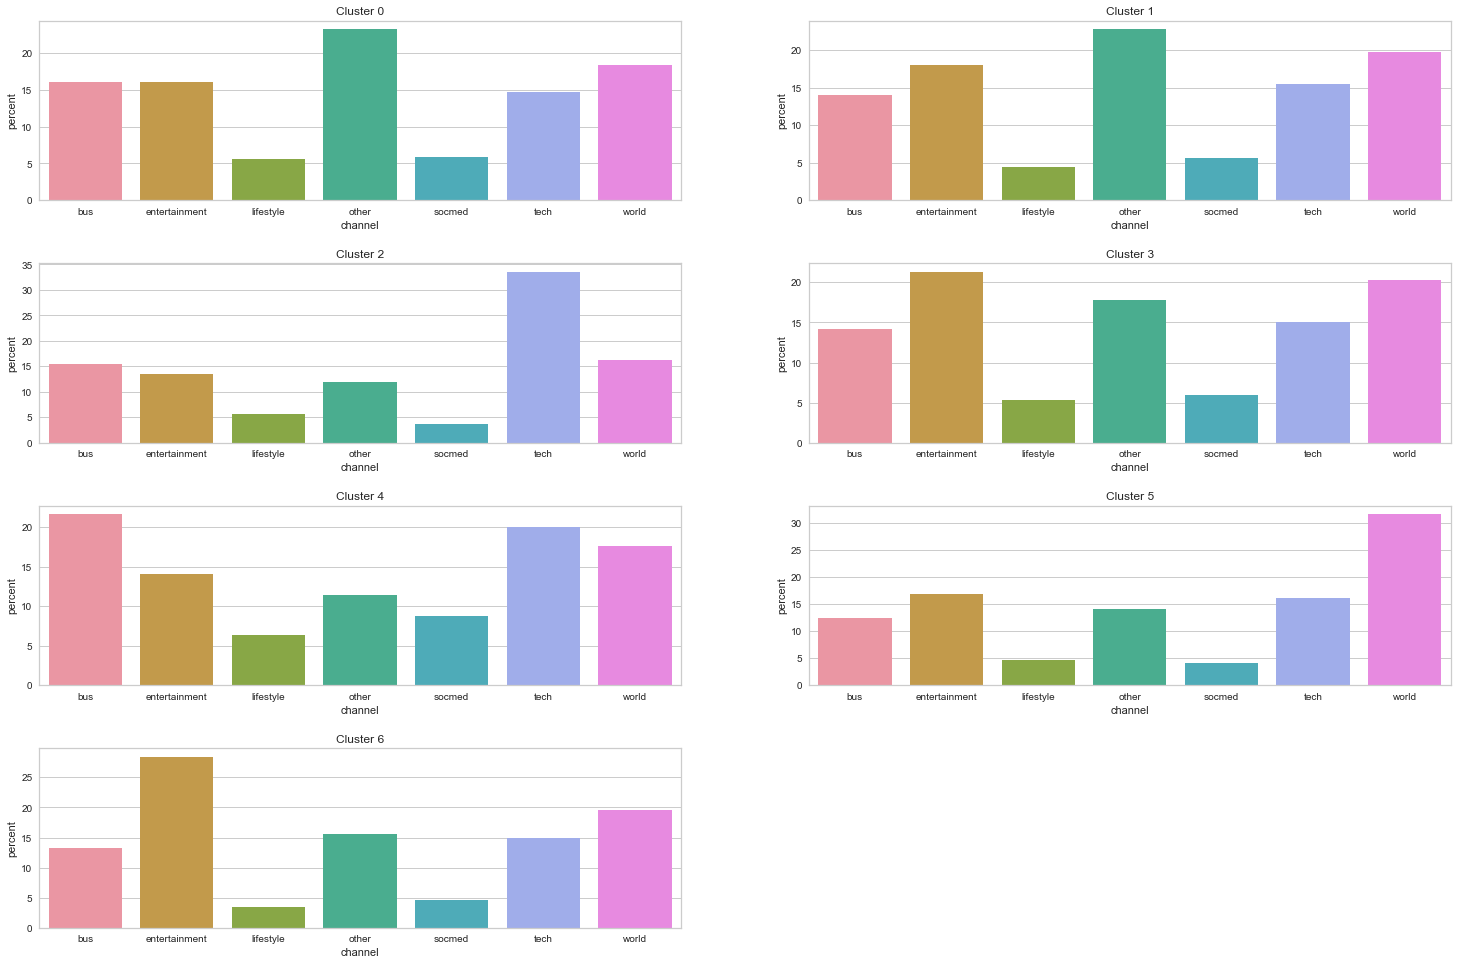

In [47]:
f, axes = plt.subplots(4, 2, figsize=(20, 14))
f.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for c in range(nltk_clusters.label.max() + 1):
    nltk_clusters_composition = nltk_clusters[nltk_clusters.label == c].groupby('channel').count().reset_index()
    nltk_clusters_composition['percent'] = nltk_clusters_composition.label / nltk_clusters_composition.label.sum() * 100
    sns.barplot(x='channel',
                y='percent',
                data=nltk_clusters_composition,
                ax=axes[int(c / 2), c % 2])
    axes[int(c / 2), c % 2].set_title('Cluster {}'.format(c))
    
_ = axes[3, 1].axis('off')

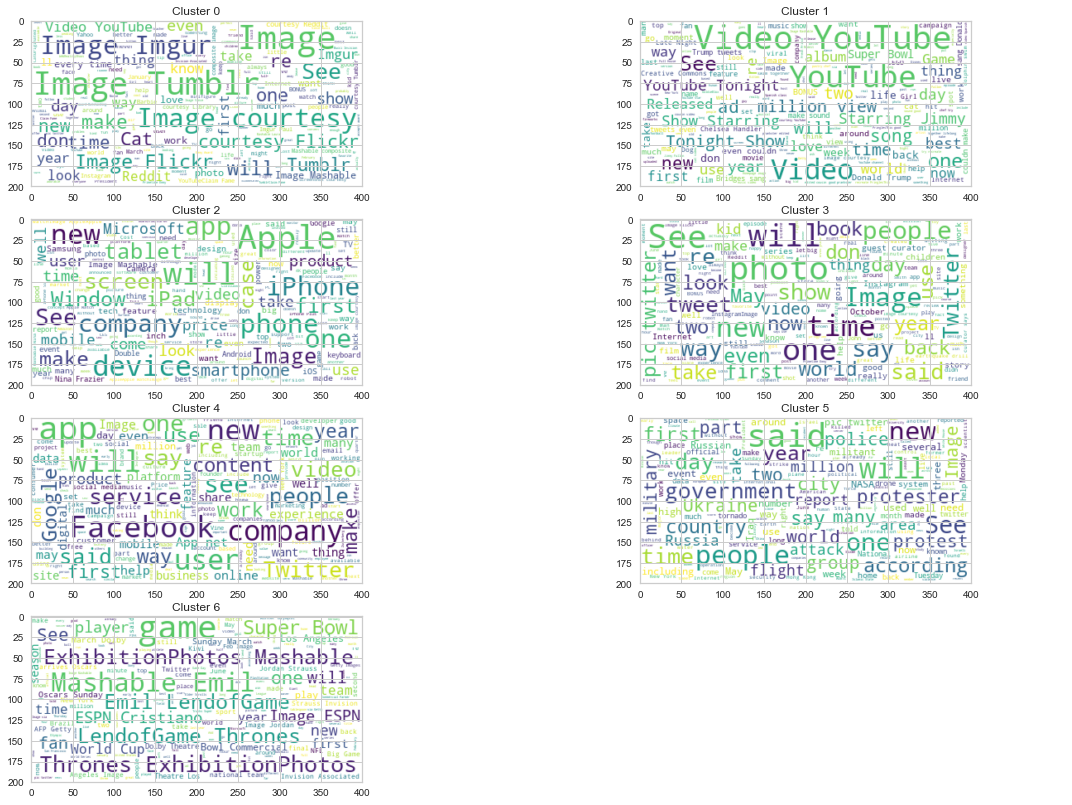

In [48]:
f, axes = plt.subplots(4, 2, figsize=(20, 14))
for c in range(nltk_clusters.label.max() + 1):
    text = ' '.join(nltk_clusters[nltk_clusters.label == c].sample(n=100).words.apply(lambda x: ' '.join(x)))
    wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=40, random_state=42).generate(text)
    axes[int(c / 2), c % 2].imshow(wordcloud, interpolation="bilinear")
    axes[int(c / 2), c % 2].set_title('Cluster {}'.format(c))    
    
_ = axes[3, 1].axis('off')

It is interesting to see that the content of cluster 0 and 1 are very similar. However, in order to evaluate the algorithm, we will assign each cluster to a unique label. After looking at the channel frequencies and the word clouds above, we think that the 7 clusters might subjectively be assigned as follows:

* 0 - other
* 1 - social media
* 2 - technology
* 3 - lifestyle
* 4 - business
* 5 - world
* 6 - entertainment

We will now use the assigned labels to compare to the true class assignments from the original dataset using the ARI metric. Since the k-means algorithm using NLTK's implementation performs better than the Scikit-Learn's implementation, we will only evaluate NLTK's k-means algorithm which uses Cosine Similiarity.

In [55]:
#referenced from https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation, 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(nltk_clusters.channel)

list(le.classes_)

['bus', 'entertainment', 'lifestyle', 'other', 'socmed', 'tech', 'world']

In [56]:
nltk_clusters.loc[nltk_clusters.label == 0, 'Pred_label'] = 'other'
nltk_clusters.loc[nltk_clusters.label == 1, 'Pred_label'] = 'socmed'
nltk_clusters.loc[nltk_clusters.label == 2, 'Pred_label'] = 'tech'
nltk_clusters.loc[nltk_clusters.label == 3, 'Pred_label'] = 'lifestyle'
nltk_clusters.loc[nltk_clusters.label == 4, 'Pred_label'] = 'bus'
nltk_clusters.loc[nltk_clusters.label == 5, 'Pred_label'] = 'world'
nltk_clusters.loc[nltk_clusters.label == 6, 'Pred_label'] = 'entertainment'

In [57]:
from sklearn import metrics

le = LabelEncoder()

le.fit(nltk_clusters.channel)
le.transform(nltk_clusters.channel)
labels_true = nltk_clusters.channel

le.fit(nltk_clusters.Pred_label)
le.transform(nltk_clusters.Pred_label)
labels_pred = nltk_clusters.Pred_label

metrics.adjusted_rand_score(labels_true, labels_pred) 

0.011171638929128138

The Adjusted Rand Index (ARI) typically ranges from -1 to 1, with a positive value denoting similar clusterings. The number we got from comparing the true and the predicted class assignments is 0.0112. Although it's a positve value, the similiarity is not strong due to the small magnitude, which is expected from observing how the instances are clustered as shown in the bar graphs and the word clouds above.

## Modeling and Evaluation 4

In summary, we did not find what we were hoping to achieve. We thought that each data channel will use a specific set of words that could help distinguish itself from the others. 

We also failed to find the right number of clusters either because the clustering method we used is not the best choice for our data or the articles are too similar to each other and can be seen as a one big cluster.

We think that the clustering analysis doesn't work well with the dataset we chose for the following two reasons:

* The dataset has 6 binary variables representing the data channel type of the articles, there are unclassified articles which are grouped into the _Other_ category. From spot checking the articles that are unclassified, we suspect that not all the articles are labeled accurately. For example, http://mashable.com/2014/12/13/un-climate-talks-peru-deadlocked/ and http://mashable.com/2014/12/14/hostage-sydney-situation/ are categorized as _Other_ but they would appear to fall under the _World_ category. Similarly, http://mashable.com/2013/01/10/shirtless-guys-water-balloons/ is classified as _Other_ but this would appear to fall under the _Entertainment_ category. Inaccurate labeling could cause the k-means algorithm to perform poorly. 

* The dataset contains unbalanced data, there are 7 different data channels (including *other*) and the proportion varies across classes. There are only about 2,000 articles for _Lifestyle_ and _Social Media_, while there are over 8,000 articles for _World_ category (as shown in the count plot in the "Data Understanding 2" section). This disproportion could generate less accurate results when applying the k-means algorithms with 7 clusters. It is also challenging to assign labels to the resulting clusters as the categories with higher number of counts could dominate. 

Having a well-labeled and balanced dataset might help us obtain better results and gain better insight. For future work, one could also utilize other natural language processing (NLP) techniques to assign class labels based on a specific set of words and use them to compare against the k-means assigned labels to see whether better results could be obtained.  

Another interesting observation that we made was a difference between the use of Cosine similarity and Euclidian distances when it comes to clustering text data. After a quick research, we found this wonderful article by Chris Emmery (https://cmry.github.io/notes/euclidean-v-cosine) who explained why Cosine similarity is a better distance metric for text classification and clustering than Euclidian metric. According to his post, Cosine similarity is better because it does not depend on the magnitude of the vectors which might depend on the length of an article. Normalization of TFIDF vector might help to make Euclidian distance work better, but in general, it looks like Cosine similarity is a preferred metric for this type of data.

Neverthesless, from this assignment, we have learned how TF-IDF algorithm works and its uses in natural language processing to retreive information from text documents for analyses. We also learned about how we can apply NLTK's implementation to use a different distance metric, such as cosine similarity, and how to evaluate a clustering algorithm using ARI metric. 

## Deployment 

As mentioned above, we did not achieve the results we had hoped in regard to classification of data channels. However, the ability to classify an article's data channel based on its content remains a lucrative business opportunity. Digital marketing companies invest significant funds in the content generation workflow. Copywriters, Proofreaders, and Content QA specialists are all involved in the creation of content articles and these salaries pose a large cost. In addition, the costs related to content distribution are not trivial. Thus, optimzing content such that it aligns with trending and popular data channels presents significant revenue and cost-saving opportunities for digital marketing companies and we believe future work is merited.

For future work, we need to focus on the 2 major problems presented with our dataset - unclassified articles and unbalanced data. For many of the unclassified articles, we noticed standard human intuition generally presented a straightforward classification. Perhaps incorportating some additional content parsing techniques such as NLP would allows us to classify more of the unclassified articles. Combining these additional techniques with our use of TF-IDF statistics could potentially improve the value of our model.

Regarding the problem of unbalanced data, it may be beneficial for us to pull in additional data sources. In our analysis, we used the Online News Popularity dataset which only used articles from Mashable. Similar data features could be pulled from sources such as Facebook or Twitter. Both sites allow for the sharing of articles, so it is feasible a process could be created to retrieve necessary data features from these sites. Digg.com could be another viable source of data. Combining data from these additional sites with our original dataset may yield a more balanced representation of data channels.

Assuming we can achieve better classification results through the mentioned avenues of future work, we will need to make our model easy to leverage by participating businesses. To achieve this, an architecture supporting service calls fits well. Client input can be processed through a data import mechanism either per article or by bulk load. Classification information can be returned to the client through service calls or a data dump. A REST API interface can be used to support the consumption of client data and return of model prediction data. This type of distributed architecture will allow us to retrain our model as needed without impacting client operations.

Finally, we need to address how frequently we should retrain our model. Evolving social trends and behavior have the potential of invalidating our predictions in a short time frame which could be very costly to a business. Invalidation timeframes for our model may vary widely across industries. Thus, we need to focus on client specific metrics to understand when our model should be retrained. If significant drops in ROAI or increases in CPL are observed, this is a good indicator it is time to incorporate fresh data and retrain our model. Retraining our model may be costly depending on the size of input data and processing power required, so supporting industry or client specific models is desirable. By utilizing the mentioned distributed architecture, retraining of models can be accomplished without business impact to clients.

## Exceptional Work

In this work we did perform NLP analysis on raw textual data extracted in our first project. Also we found and fixed a problem in NLTK's k-means implementation. On top of clustering, we also decided to look at Latent Semantic Analysis (LSA) and Sentiment Classification of news articles. We found the work of Susan Li's as she described it in her article in Towards Data Science: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3 interesting and decided to reproduce her approach with our dataset.

In [115]:
shares_df = df[['url', 'shares']]
shares_df.head(2)

,url,shares
0,http://mashable.com/2013/01/07/amazon-instant-video-browser/,593
1,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,711


In [116]:
sentiment_df = pd.merge(text_df[['status_code', 'url', 'text']],
                 shares_df[['url', 'shares']],
                 on='url')
sentiment_df.head()

,status_code,url,text,shares
0,200,http://mashable.com/2013/01/07/amazon-instant-video-browser/,"\nHaving trouble finding something to watch on Amazon Instant Video? The retailer launched Monday an experimental browsing tool that lets users discover movies and TV shows based on their genre preferences or simply the mood they're in.\nMovies and shows are divided up into categories, some of which bear the names of genres (i.e., ""Comedy"" and ""Mystery/Thriller""), and others which are labeled by mood, such as ""Feel-Good"" and ""Exciting."" Users can toggle between TV shows and movies, and apply filters to show only videos that are available for free viewing to Prime subscribers, or ones that bear G or PG ratings.\nIt's pretty basic, but it sure beats the haphazard organization of Amazon's current Instant Video page, which mixes rows of new releases with bestsellers and personal recommendations.\nThe move is the latest in a series of investment's Amazon is making in its streaming video platform. Last week, the company inked a licensing agreement with A+E Networks to bring past seasons...",593
1,200,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,"\nThe Associated Press is the latest news organization to experiment with trying to make money from Twitter by using its feed to advertise for other companies. \nThe AP announced Monday that it will share sponsored tweets from Samsung throughout this week for the International CES taking place in Las Vegas. The news service will let Samsung post two tweets per day to the AP's Twitter account, which has more than 1.5 million users, and each of these tweets will be labeled ""SPONSORED TWEETS.""\nThis marks the first time that the AP has sold advertising on its Twitter feed, and the company says it spent months developing guidelines to pave the way for this and other new media business models. \nFor this particular promotion, Samsung will provide the sponsored tweets and non-editorial staff at the AP will handle the publishing side. In this way, the company hopes to maintain a clear dividing line between its editorial and advertising operations on Twitter.\n""We are thrilled to be takin...",711
2,200,http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,"\nIt looks like 2012 was a pretty good year for Apple's App Store.\nApple announced Monday that the App Store has now passed 40 billion downloads since launching in 2008, with nearly 20 billion apps downloaded in 2012. The company had a particularly strong holiday season, with 2 billion app downloads in December alone.\nThe App Store hit the 25 billion mark in March and passed 35 billion in October. \nâ€œIt has been an incredible year for the iOS developer community,â€ said Eddy Cue, Appleâ€™s senior vice president of Internet Software and Services, in a statement. â€œDevelopers have made over $7 billion on the App Store, and we continue to invest in providing them with the best ecosystem so they can create the most innovative apps in the world.â€\nJust as importantly, the company revealed that there are now more than 500 million active accounts in the App Store, showing the growth of Apple's user base. \nIn total, there are now 775,000 apps in Apple's App Store, with more than ...",1500
3,200,http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,"\nWhen it comes to college football, NASA astronaut Kevin Ford is Irish through and through. Ford will be rooting for Notre Dame all the way from space during the BCS Championship game against Alabama tonight.\nFord is currently living on the International Space Station, where he commands a six-man team, but tonight his heart will be with Notre Dame —his alma mater —when the team faces off with Alabama's Crimson Tide in Miami.\n""The team's played great,"" Ford said in a recent interview with Notre Dame officials on NASA TV. ""Obviously the defense is very special, and the offense is just really clicking. I'm looking forward to a great game on the seventh of January.""\

In [117]:
sentiment_df['shares'].describe()

count     39629.000000
mean       3395.438719
std       11629.067229
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

In [118]:
def to_score(v):
    if v <= 1: return '1'
    elif v <= 946: return '2'
    elif v <= 1400: return '3'
    elif v <= 2800: return '4'
    else: return '5'

In [119]:
sentiment_df['score'] = sentiment_df.shares.apply(to_score)

In [121]:
for att in ['status_code', 'shares', 'score']:
    sentiment_df[att] = sentiment_df[att].astype('int')

In [122]:
sentiment_df.head()

,status_code,url,text,shares,score
0,200,http://mashable.com/2013/01/07/amazon-instant-video-browser/,"\nHaving trouble finding something to watch on Amazon Instant Video? The retailer launched Monday an experimental browsing tool that lets users discover movies and TV shows based on their genre preferences or simply the mood they're in.\nMovies and shows are divided up into categories, some of which bear the names of genres (i.e., ""Comedy"" and ""Mystery/Thriller""), and others which are labeled by mood, such as ""Feel-Good"" and ""Exciting."" Users can toggle between TV shows and movies, and apply filters to show only videos that are available for free viewing to Prime subscribers, or ones that bear G or PG ratings.\nIt's pretty basic, but it sure beats the haphazard organization of Amazon's current Instant Video page, which mixes rows of new releases with bestsellers and personal recommendations.\nThe move is the latest in a series of investment's Amazon is making in its streaming video platform. Last week, the company inked a licensing agreement with A+E Networks to bring past seasons...",593,2
1,200,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,"\nThe Associated Press is the latest news organization to experiment with trying to make money from Twitter by using its feed to advertise for other companies. \nThe AP announced Monday that it will share sponsored tweets from Samsung throughout this week for the International CES taking place in Las Vegas. The news service will let Samsung post two tweets per day to the AP's Twitter account, which has more than 1.5 million users, and each of these tweets will be labeled ""SPONSORED TWEETS.""\nThis marks the first time that the AP has sold advertising on its Twitter feed, and the company says it spent months developing guidelines to pave the way for this and other new media business models. \nFor this particular promotion, Samsung will provide the sponsored tweets and non-editorial staff at the AP will handle the publishing side. In this way, the company hopes to maintain a clear dividing line between its editorial and advertising operations on Twitter.\n""We are thrilled to be takin...",711,2
2,200,http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,"\nIt looks like 2012 was a pretty good year for Apple's App Store.\nApple announced Monday that the App Store has now passed 40 billion downloads since launching in 2008, with nearly 20 billion apps downloaded in 2012. The company had a particularly strong holiday season, with 2 billion app downloads in December alone.\nThe App Store hit the 25 billion mark in March and passed 35 billion in October. \nâ€œIt has been an incredible year for the iOS developer community,â€ said Eddy Cue, Appleâ€™s senior vice president of Internet Software and Services, in a statement. â€œDevelopers have made over $7 billion on the App Store, and we continue to invest in providing them with the best ecosystem so they can create the most innovative apps in the world.â€\nJust as importantly, the company revealed that there are now more than 500 million active accounts in the App Store, showing the growth of Apple's user base. \nIn total, there are now 775,000 apps in Apple's App Store, with more than ...",1500,4
3,200,http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,"\nWhen it comes to college football, NASA astronaut Kevin Ford is Irish through and through. Ford will be rooting for Notre Dame all the way from space during the BCS Championship game against Alabama tonight.\nFord is currently living on the International Space Station, where he commands a six-man team, but tonight his heart will be with Notre Dame —his alma mater —when the team faces off with Alabama's Crimson Tide in Miami.\n""The team's played great,"" Ford said in a recent interview with Notre Dame officials on NASA TV. ""Obviously the defense is very special, and the offense is just really clicking. I'm looking forward to a great game on the seventh of

#### TFIDF
First, let's extract TF-IDF features from the news articles.

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(sentiment_df['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [124]:
X = tfidf.transform(sentiment_df['text'])
sentiment_df['text'][1]

'\nThe Associated Press is the latest news organization to experiment with trying to make money from Twitter by using its feed to advertise for other companies. \nThe AP announced Monday that it will share sponsored tweets from Samsung throughout this week for the International CES taking place in Las Vegas. The news service will let Samsung post two tweets per day to the AP\'s Twitter account, which has more than 1.5 million users, and each of these tweets will be labeled "SPONSORED TWEETS."\nThis marks the first time that the AP has sold advertising on its Twitter feed, and the company says it spent months developing guidelines to pave the way for this and other new media business models. \nFor this particular promotion, Samsung will provide the sponsored tweets and non-editorial staff at the AP will handle the publishing side. In this way, the company hopes to maintain a clear dividing line between its editorial and advertising operations on Twitter.\n"We are thrilled to be taking t

In [125]:
X.shape

(39629, 231987)

In [126]:
# In reference to the above document, we can check out tfidf scores for a few words within the document.
print([X[1, tfidf.vocabulary_['revenues']]])
print([X[1, tfidf.vocabulary_['news']]])
print([X[1, tfidf.vocabulary_['tweets']]])

[0.07733391008632996]
[0.10592280663509511]
[0.2593379657672328]


The higher the TF-IDF score, the rarer the word and vice versa. Among the three, it looks like "tweets" is a less frequently used word than "revenues" and "news".

#### Sentiment Classification
In Susan's atricle, she suggested to remove neutral score of 3, then group score 4 and 5 to be positive (1), and score 1 and 2 to be negative (0) to classify sentiment.

In [127]:
import numpy as np

sentiment_df.dropna(inplace=True)
sentiment_df[sentiment_df['score'] != 3]
sentiment_df['positivity'] = np.where(sentiment_df['score'] > 3, 1, 0)
cols = ['status_code', 'url', 'shares']
sentiment_df.drop(cols, axis=1, inplace=True)
sentiment_df.head()

,text,score,positivity
0,"\nHaving trouble finding something to watch on Amazon Instant Video? The retailer launched Monday an experimental browsing tool that lets users discover movies and TV shows based on their genre preferences or simply the mood they're in.\nMovies and shows are divided up into categories, some of which bear the names of genres (i.e., ""Comedy"" and ""Mystery/Thriller""), and others which are labeled by mood, such as ""Feel-Good"" and ""Exciting."" Users can toggle between TV shows and movies, and apply filters to show only videos that are available for free viewing to Prime subscribers, or ones that bear G or PG ratings.\nIt's pretty basic, but it sure beats the haphazard organization of Amazon's current Instant Video page, which mixes rows of new releases with bestsellers and personal recommendations.\nThe move is the latest in a series of investment's Amazon is making in its streaming video platform. Last week, the company inked a licensing agreement with A+E Networks to bring past seasons...",2,0
1,"\nThe Associated Press is the latest news organization to experiment with trying to make money from Twitter by using its feed to advertise for other companies. \nThe AP announced Monday that it will share sponsored tweets from Samsung throughout this week for the International CES taking place in Las Vegas. The news service will let Samsung post two tweets per day to the AP's Twitter account, which has more than 1.5 million users, and each of these tweets will be labeled ""SPONSORED TWEETS.""\nThis marks the first time that the AP has sold advertising on its Twitter feed, and the company says it spent months developing guidelines to pave the way for this and other new media business models. \nFor this particular promotion, Samsung will provide the sponsored tweets and non-editorial staff at the AP will handle the publishing side. In this way, the company hopes to maintain a clear dividing line between its editorial and advertising operations on Twitter.\n""We are thrilled to be takin...",2,0
2,"\nIt looks like 2012 was a pretty good year for Apple's App Store.\nApple announced Monday that the App Store has now passed 40 billion downloads since launching in 2008, with nearly 20 billion apps downloaded in 2012. The company had a particularly strong holiday season, with 2 billion app downloads in December alone.\nThe App Store hit the 25 billion mark in March and passed 35 billion in October. \nâ€œIt has been an incredible year for the iOS developer community,â€ said Eddy Cue, Appleâ€™s senior vice president of Internet Software and Services, in a statement. â€œDevelopers have made over $7 billion on the App Store, and we continue to invest in providing them with the best ecosystem so they can create the most innovative apps in the world.â€\nJust as importantly, the company revealed that there are now more than 500 million active accounts in the App Store, showing the growth of Apple's user base. \nIn total, there are now 775,000 apps in Apple's App Store, with more than ...",4,1
3,"\nWhen it comes to college football, NASA astronaut Kevin Ford is Irish through and through. Ford will be rooting for Notre Dame all the way from space during the BCS Championship game against Alabama tonight.\nFord is currently living on the International Space Station, where he commands a six-man team, but tonight his heart will be with Notre Dame —his alma mater —when the team faces off with Alabama's Crimson Tide in Miami.\n""The team's played great,"" Ford said in a recent interview with Notre Dame officials on NASA TV. ""Obviously the defense is very special, and the offense is just really clicking. I'm looking forward to a great game on the seventh of January.""\n\nFord has been living on the space station since October, when he blasted off aboard a Russian Soyuz rocket. He took charge of the space station's Expedition 34 crew a month later and will return to Earth in March. He is a native of Montpelier, Ind., and is a re

In [128]:
from sklearn.model_selection import train_test_split
X = sentiment_df.text
y = sentiment_df.positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train), 
(len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
(len(X_train[y_train == 1]) / (len(X_train)*1.))*100))


Train set has total 29721 entries with 50.50% negative, 49.50% positive


In [129]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
(len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
(len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 9908 entries with 51.17% negative, 48.83% positive


In [130]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

Next, we will apply RandomForestClassifier to figure out the number of features we need.

In [131]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,10000)
def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 10000 features
accuracy score: 51.18%
Test result for 20000 features
accuracy score: 51.35%
Test result for 30000 features
accuracy score: 51.81%


Let's look at the statistics from the classification report to evaluate how well the algorithm performs.

In [132]:
from sklearn.metrics import classification_report
cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.52      0.66      0.58      5070
    positive       0.51      0.37      0.43      4838

   micro avg       0.52      0.52      0.52      9908
   macro avg       0.51      0.51      0.50      9908
weighted avg       0.51      0.52      0.51      9908



For some reason, we did not achieve the same precision, recall and f1-score as Susan with our dataset.

#### Chi-Squared for Feature Selection

Susan conducted a Chi-square test to perform feature selection on her dataset. We also decided to calculate the Chi square scores for all the features and visualize the top 20, where terms are the features, and positive and negative are the two classes.

In [133]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(sentiment_df.text)
y = sentiment_df.positivity
chi2score = chi2(X_tfidf, y)[0]

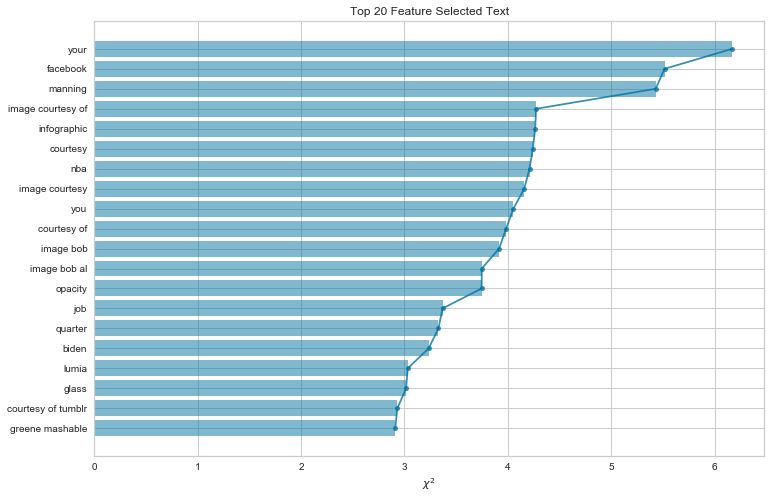

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.title('Top 20 Feature Selected Text')
plt.show();

The top 5 most useful feature selected by Chi-square test are “your”, “facebook”, “manning”, “image courtesy of” and “infographic”. I assume they are mostly from negative reviews. The next most useful feature selected by Chi-square test is “courtesy”, we assume it is mostly from the positive reviews, as described in Susan Li's article.